In [196]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [197]:
cd /content/drive/MyDrive/07_Competition/fudosan/src

/content/drive/MyDrive/07_Competition/fudosan/src


In [198]:
! pip install japanize_matplotlib
! pip install category_encoders
! pip install xfeat

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from glob import glob
from IPython.display import Image
import japanize_matplotlib
import missingno as msno
import re
import math
%matplotlib inline
from scipy import stats

import seaborn as sns

import string
from sklearn.metrics import mean_absolute_error
from matplotlib_venn import venn2
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.model_selection import KFold, StratifiedKFold
from contextlib import contextmanager
from time import time

import warnings
warnings.simplefilter('ignore')

import preprocess_module
import visualize_module
import importlib

importlib.reload(preprocess_module)
importlib.reload(visualize_module)

<module 'visualize_module' from '/content/drive/MyDrive/07_Competition/fudosan/src/visualize_module.py'>

In [200]:
class CFG:
  exp = "exp01"
  seed = 71
  fold = 10

CONFIG = CFG()

In [201]:
input_dir = "/content/drive/MyDrive/07_Competition/fudosan/data/"
output_dir = "/content/drive/MyDrive/07_Competition/fudosan/submit/"

In [202]:
pd.set_option("display.max_colwidth", 50)

# Import file
paths = glob(input_dir + 'train/*.csv')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(input_dir + 'test.csv')

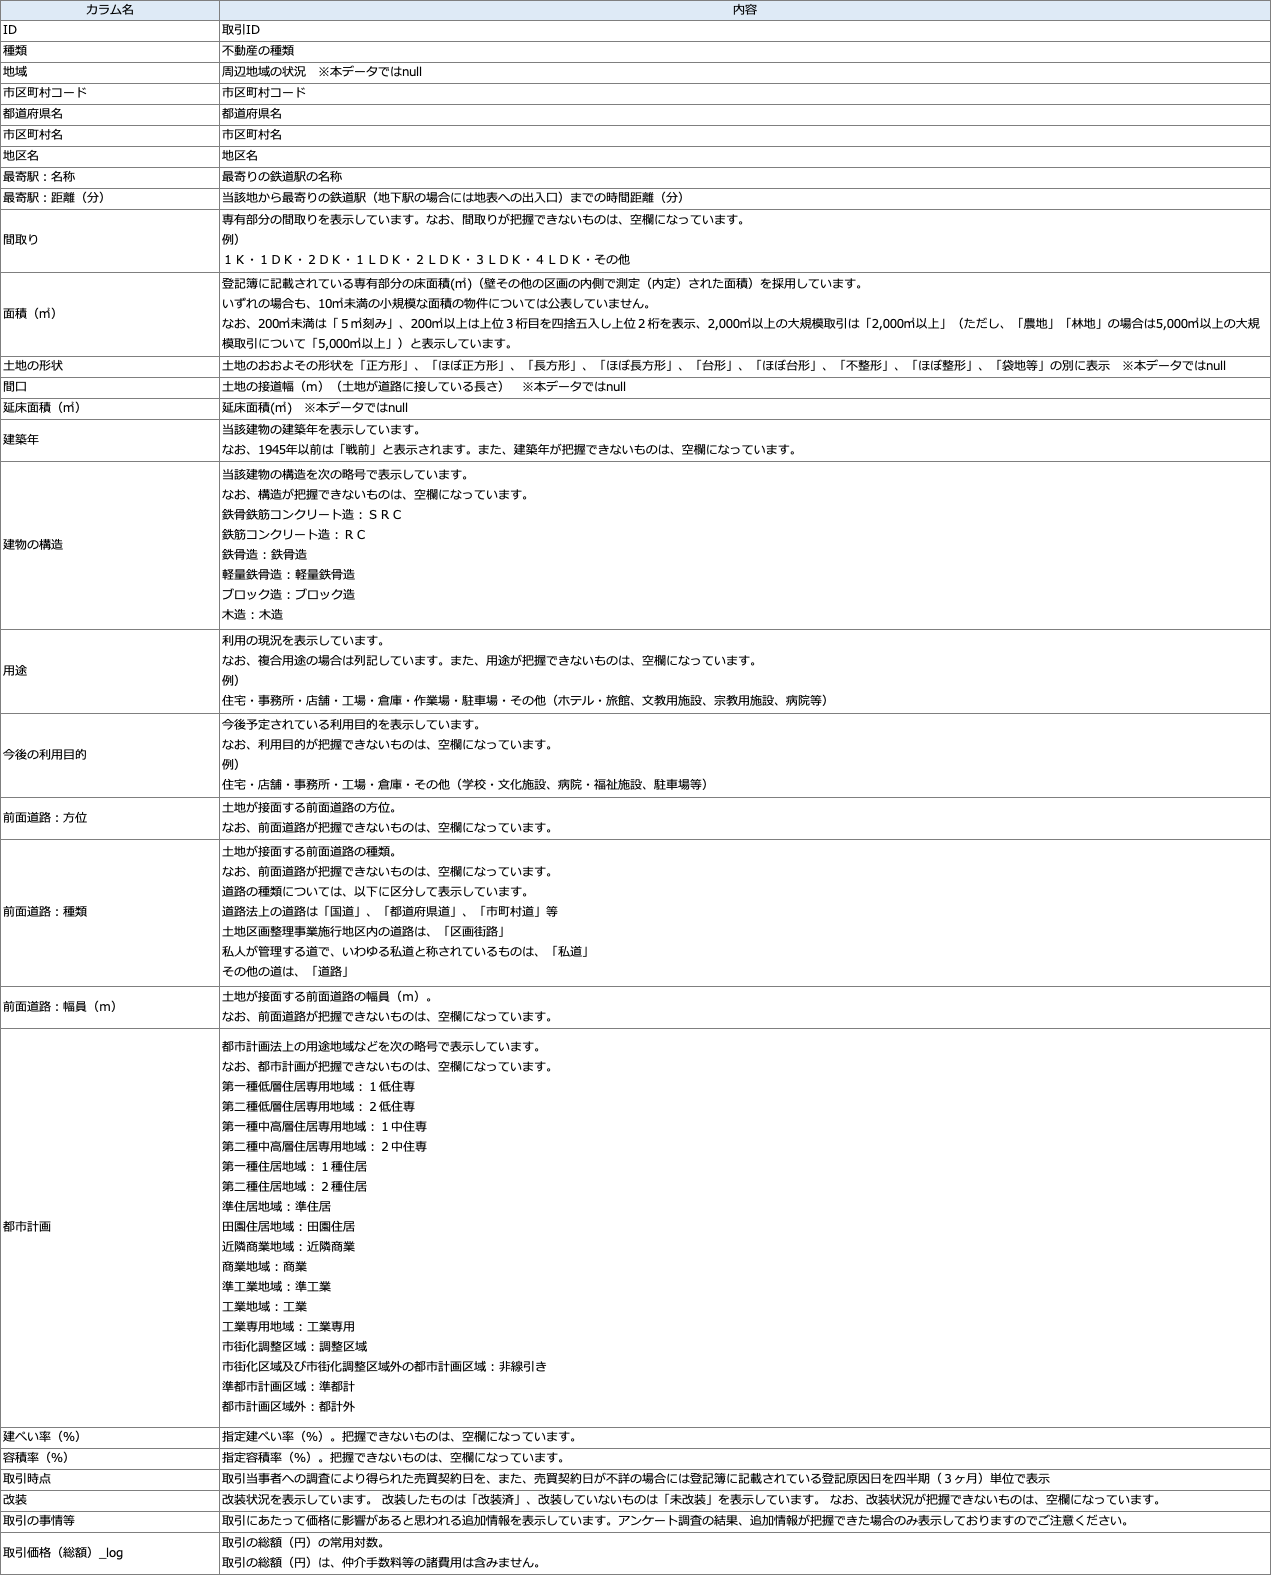

In [203]:
Image(input_dir +"image_1.png", width = 1200)

In [204]:
train_df.head()

,ID,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,土地の形状,間口,延床面積（㎡）,建築年,建物の構造,用途,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,4018044,中古マンション等,NaN,4103,宮城県,仙台市若林区,大和町,仙台,30分?60分,３ＬＤＫ,70,NaN,NaN,NaN,平成3年,ＳＲＣ,住宅,NaN,NaN,NaN,NaN,商業地域,80.0,400.0,2010年第４四半期,未改装,NaN,6.944483
1,4010601,中古マンション等,NaN,4101,宮城県,仙台市青葉区,星陵町,北四番丁,15,３Ｋ,45,NaN,NaN,NaN,昭和59年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2007年第４四半期,改装済,NaN,6.929419
2,4014959,中古マンション等,NaN,4102,宮城県,仙台市宮城野区,栄,中野栄,7,３ＬＤＫ,65,NaN,NaN,NaN,平成18年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2011年第２四半期,未改装,NaN,7.230449
3,4004466,中古マンション等,NaN,4101,宮城県,仙台市青葉区,梅田町,東照宮,9,３ＬＤＫ,65,NaN,NaN,NaN,昭和63年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第２種住居地域,60.0,200.0,2012年第２四半期,改装済,NaN,7.079181
4,4002715,中古マンション等,NaN,4101,宮城県,仙台市青葉区,国見,東北福祉大前,15,３ＬＤＫ,60,NaN,NaN,NaN,平成7年,ＲＣ,住宅,NaN,NaN,NaN,NaN,第１種低層住居専用地域,50.0,80.0,2010年第４四半期,未改装,NaN,6.812913


In [205]:
train_df.shape

(662799, 28)

In [206]:
test_df.shape

(23204, 27)

In [207]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662799 entries, 0 to 662798
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            662799 non-null  int64  
 1   種類            662799 non-null  object 
 2   地域            0 non-null       float64
 3   市区町村コード       662799 non-null  int64  
 4   都道府県名         662799 non-null  object 
 5   市区町村名         662799 non-null  object 
 6   地区名           662141 non-null  object 
 7   最寄駅：名称        660149 non-null  object 
 8   最寄駅：距離（分）     639723 non-null  object 
 9   間取り           639845 non-null  object 
 10  面積（㎡）         662799 non-null  object 
 11  土地の形状         0 non-null       float64
 12  間口            0 non-null       float64
 13  延床面積（㎡）       0 non-null       float64
 14  建築年           643672 non-null  object 
 15  建物の構造         647204 non-null  object 
 16  用途            608856 non-null  object 
 17  今後の利用目的       299327 non-null  object 
 18  前面道路

## Utilities

In [208]:
# set seed
def seed_everything(seed=71):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)


## 欠損値確認

In [209]:
def get_null_df(features):
    col_null_df = pd.DataFrame(columns = ['Column', 'Type', 'Total NaN', '%'])
    col_null = features.columns[features.isna().any()].to_list()
    L = len(features)
    for col in col_null:
        T = 0
        if features[col].dtype == "float64":
            T = "Numerical"  
        elif features[col].dtype == "int64":
            T = "Numerical"  
        else:
            T = "Categorical"
        nulls = len(features[features[col].isna() == True][col])   
        col_null_df = col_null_df.append({'Column': col, 
                                          'Type': T,
                                          'Total NaN': nulls,
                                          '%': (nulls / L)*100
                                         }, ignore_index=True)
    return col_null_df

def get_unique_df(features):
    unique_df = pd.DataFrame(columns=['Feature', 'Unique', 'Count'])
    for col in features.columns:
        v = features[col].unique()
        l = len(v)
        unique_df = unique_df.append({'Feature':col, 
                                     'Unique':v,
                                     'Count':l}, ignore_index=True)
    return unique_df

In [210]:
get_unique_df(train_df)

,Feature,Unique,Count
0,ID,"[4018044, 4010601, 4014959, 4004466, 4002715, ...",662799
1,種類,[中古マンション等],1
2,地域,[nan],1
3,市区町村コード,"[4103, 4101, 4102, 4105, 4104, 4215, 4202, 420...",618
4,都道府県名,"[宮城県, 岩手県, 福島県, 茨城県, 山形県, 青森県, 栃木県, 秋田県, 北海道, ...",47
5,市区町村名,"[仙台市若林区, 仙台市青葉区, 仙台市宮城野区, 仙台市泉区, 仙台市太白区, 大崎市, ...",618
6,地区名,"[大和町, 星陵町, 栄, 梅田町, 国見, 一番町, 荒巻本沢, 福田町, 榴岡, 台原,...",12091
7,最寄駅：名称,"[仙台, 北四番丁, 中野栄, 東照宮, 東北福祉大前, 青葉通一番町, 北山(宮城), 福...",3847
8,最寄駅：距離（分）,"[30分?60分, 15, 7, 9, 4, 8, 13, 5, 10, 6, 16, 2,...",35
9,間取り,"[３ＬＤＫ, ３Ｋ, ２ＤＫ, ２ＬＤＫ, ４ＬＤＫ, １Ｋ, nan, ２ＤＫ＋Ｓ, ３Ｄ...",64


In [211]:
get_null_df(train_df)

,Column,Type,Total NaN,%
0,地域,Numerical,662799,100.000000
1,地区名,Categorical,658,0.099276
2,最寄駅：名称,Categorical,2650,0.399820
3,最寄駅：距離（分）,Categorical,23076,3.481598
4,間取り,Categorical,22954,3.463192
5,土地の形状,Numerical,662799,100.000000
6,間口,Numerical,662799,100.000000
7,延床面積（㎡）,Numerical,662799,100.000000
8,建築年,Categorical,19127,2.885792
9,建物の構造,Categorical,15595,2.352900


## 特徴量カテゴリーの確認

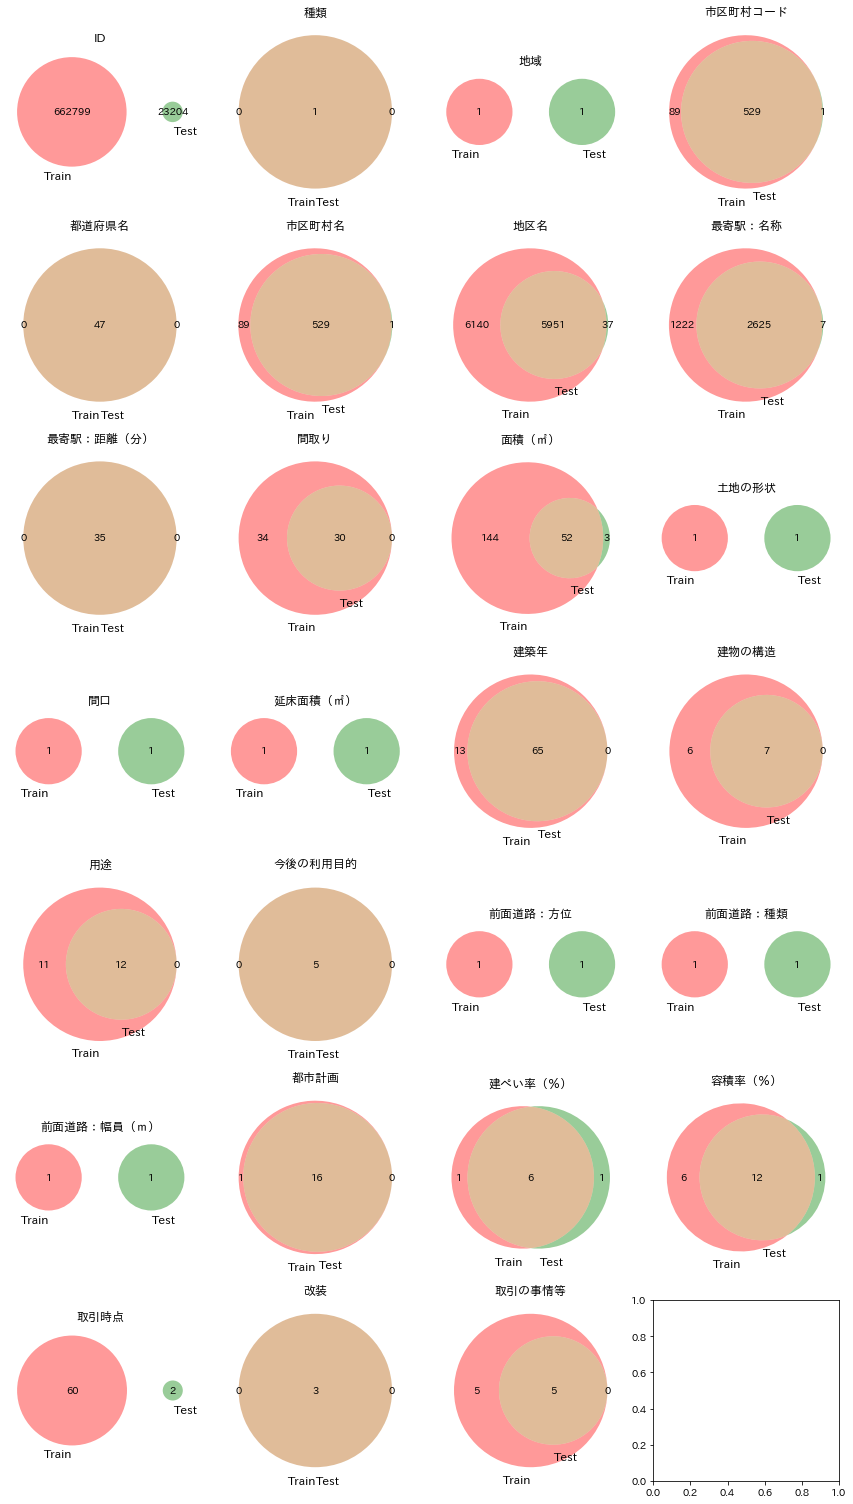

In [212]:
#目的変数を除くベン図の作成
vs = visualize_module.Feature_Confirmation()

vs.Venn_plot(train_df,test_df)

In [213]:
train_df = train_df[['ID', 
                     #'種類',
                     #'地域',
                     '市区町村コード', 
                     '都道府県名', 
                     '市区町村名', 
                     '地区名',
                     '最寄駅：名称',
                     '最寄駅：距離（分）',
                     '間取り', 
                     '面積（㎡）', 
                     #'土地の形状', 
                     #'間口',
                     #'延床面積（㎡）',
                     '建築年',
                     '建物の構造',
                     '用途', 
                     '今後の利用目的',
                     #'前面道路：方位', 
                     #'前面道路：種類',
                     #'前面道路：幅員（ｍ）',
                     '都市計画', 
                     '建ぺい率（％）',
                     '容積率（％）',
                     '取引時点', 
                     '改装',
                     '取引の事情等',
                     '取引価格（総額）_log']]

test_df = test_df[['ID', 
                     #'種類',
                     #'地域',
                     '市区町村コード', 
                     '都道府県名', 
                     '市区町村名', 
                     '地区名',
                     '最寄駅：名称',
                     '最寄駅：距離（分）',
                     '間取り', 
                     '面積（㎡）', 
                     #'土地の形状', 
                     #'間口',
                     #'延床面積（㎡）',
                     '建築年',
                     '建物の構造',
                     '用途', 
                     '今後の利用目的',
                     #'前面道路：方位', 
                     #'前面道路：種類',
                     #'前面道路：幅員（ｍ）',
                     '都市計画', 
                     '建ぺい率（％）',
                     '容積率（％）',
                     '取引時点', 
                     '改装',
                     '取引の事情等']]

## Uniqueな特徴量の確認

In [214]:
def check_unique(train_df,test_df,columns):
    for column in columns:
        print("------------TRAIN-----------------")
        print(train_df[column].unique())
        display(train_df[column].value_counts())
        print("-------------TEST----------------")
        print(test_df[column].unique())
        display(test_df[column].value_counts())
        print("=====================")
        print(" ")

columns=[
        #'市区町村名', 
        #'地区名',
        #'最寄駅：名称',
        '最寄駅：距離（分）',
        '間取り', 
        '面積（㎡）', 
        #'土地の形状', 
        #'間口',
        #'延床面積（㎡）',
        '建築年',
        '建物の構造',
        '用途', 
        '今後の利用目的',
        #'前面道路：方位', 
        #'前面道路：種類',
        #'前面道路：幅員（ｍ）',
        '都市計画', 
        '建ぺい率（％）',
        '容積率（％）',
        '取引時点', 
        '改装',
        '取引の事情等']

check_unique(train_df,test_df,columns)

------------TRAIN-----------------
['30分?60分' '15' '7' '9' '4' '8' '13' '5' '10' '6' '16' '2' '19' '3' '12'
 nan '14' '25' '1H?1H30' '21' '2H?' '28' '11' '20' '23' '1H30?2H' '29'
 '26' '0' '22' '18' '24' '1' '17' '27']


6          53019
4          51083
5          47415
8          46181
3          44839
9          39997
7          33735
30分?60分    33100
10         32924
11         31888
2          28317
13         23746
1          20558
14         19506
15         19277
12         15734
16         14899
18         12115
19         10921
20          9243
21          7421
23          6908
25          6400
24          5093
28          4268
26          4141
0           3856
1H?1H30     3747
29          3720
17          2578
22          1104
2H?          861
1H30?2H      710
27           419
Name: 最寄駅：距離（分）, dtype: int64

-------------TEST----------------
['2' '3' '1' '6' '4' '13' '8' '7' '5' '10' '9' '11' '15' '30分?60分' '16'
 '14' '23' '24' '25' '26' '28' '0' '19' '18' '20' '17' '21' '12' '22'
 '2H?' '1H?1H30' '29' '27' '1H30?2H' nan]


4          1991
6          1984
5          1803
8          1723
3          1717
9          1474
7          1348
10         1256
11         1122
30分?60分    1069
2          1048
13          790
1           717
15          684
14          671
12          640
16          485
18          420
19          373
20          310
21          232
25          219
23          205
24          180
0           136
26          119
28          116
1H?1H30     116
29          102
17           49
2H?          43
1H30?2H      21
22           20
27            8
Name: 最寄駅：距離（分）, dtype: int64

 
------------TRAIN-----------------
['３ＬＤＫ' '３Ｋ' '２ＤＫ' '２ＬＤＫ' '４ＬＤＫ' '１Ｋ' nan '２ＤＫ＋Ｓ' '３ＤＫ' '１ＤＫ' '２ＬＤＫ＋Ｓ'
 '１Ｒ' 'オープンフロア' '１ＬＤＫ' '１ＬＤＫ＋Ｓ' '２Ｋ' '４ＤＫ' '５ＬＤＫ' '３ＤＫ＋Ｓ' '３ＬＤＫ＋Ｓ' '１ＤＫ＋Ｓ'
 '４ＬＤＫ＋Ｓ' '３ＬＫ' '５ＤＫ' '１ＤＫ＋Ｋ' '３Ｋ＋Ｓ' '３ＬＤ' '４Ｋ' '４Ｌ＋Ｋ' 'メゾネット' '１ＬＫ' '２ＬＫ'
 '２Ｋ＋Ｓ' '５ＬＤＫ＋Ｓ' '２Ｌ' '１Ｌ' '４ＤＫ＋Ｓ' '１Ｒ＋Ｓ' '６ＬＤＫ' '２ＬＤ＋Ｓ' '４ＬＤＫ＋Ｋ' '２ＬＫ＋Ｓ'
 '７ＬＤＫ' '１ＬＤ＋Ｓ' '５Ｋ' '４Ｄ' '３Ｄ' '３ＬＤＫ＋Ｋ' '６ＬＤＫ＋Ｓ' 'スタジオ' '１Ｋ＋Ｓ' '３ＬＤ＋Ｓ'
 '１Ｌ＋Ｓ' '２ＬＤ' '６ＤＫ' '２Ｄ' '５ＬＤＫ＋Ｋ' '２ＬＤＫ＋Ｋ' '８ＬＤＫ' '７ＬＤＫ＋Ｓ' '８ＬＤＫ＋Ｓ' '４Ｌ'
 '２Ｌ＋Ｓ' '７ＤＫ']


３ＬＤＫ      282623
１Ｋ         96505
２ＬＤＫ       95428
４ＬＤＫ       60588
１ＬＤＫ       28060
           ...  
４Ｌ             1
２ＬＤＫ＋Ｋ         1
４Ｄ             1
１Ｌ＋Ｓ           1
５ＬＤＫ＋Ｋ         1
Name: 間取り, Length: 63, dtype: int64

-------------TEST----------------
['１ＬＤＫ' '２ＬＤＫ' '１Ｋ' '３ＬＤＫ' '２ＤＫ' '４ＬＤＫ' '３ＤＫ' 'オープンフロア' '１ＤＫ' '１Ｒ' nan
 'メゾネット' '５ＬＤＫ' '４ＤＫ' '３Ｋ' '２ＬＤＫ＋Ｓ' '２ＤＫ＋Ｓ' '２Ｋ' '３ＬＤＫ＋Ｓ' '１ＬＤＫ＋Ｓ' '４Ｋ'
 '３ＤＫ＋Ｓ' '１Ｌ' 'スタジオ' '１ＤＫ＋Ｓ' '５ＬＤＫ＋Ｓ' '３ＬＫ' '６ＬＤＫ' '５ＤＫ' '１Ｋ＋Ｓ']


３ＬＤＫ       9083
１Ｋ         4106
２ＬＤＫ       3617
４ＬＤＫ       1760
１ＬＤＫ       1228
２ＤＫ         691
１ＤＫ         634
３ＤＫ         281
１Ｒ          188
オープンフロア     127
２ＬＤＫ＋Ｓ      123
４ＤＫ          39
１ＬＤＫ＋Ｓ       37
２Ｋ           29
３ＬＤＫ＋Ｓ       29
５ＬＤＫ         22
３Ｋ           12
２ＤＫ＋Ｓ        10
５ＬＤＫ＋Ｓ        5
３ＤＫ＋Ｓ         2
メゾネット         2
５ＤＫ           2
３ＬＫ           2
１Ｌ            1
６ＬＤＫ          1
スタジオ          1
４Ｋ            1
１ＤＫ＋Ｓ         1
１Ｋ＋Ｓ          1
Name: 間取り, dtype: int64

 
------------TRAIN-----------------
[70 45 65 60 55 105 90 80 25 20 75 50 85 40 35 15 30 95 100 110 125 145
 115 490 220 130 160 120 155 135 10 140 165 450 530 170 180 470 300 150
 '70' '30' '65' '80' '130' '20' '60' '55' '75' '40' '25' '85' '45' '90'
 '140' '35' '50' '15' '110' '125' '100' '105' '115' '120' '95' '145'
 '2000㎡以上' 970 600 390 440 175 190 710 200 185 250 210 260 360 740 330 230
 580 1000 290 240 460 420 270 195 320 860 500 310 340 350 370 630 280 1200
 430 680 1500 520 590 1400 380 820 410 480 700 720 560 730 870 1300 990
 '10' '135' '160' '150' '180' '210' '195' '220' '170' '165' '155' '185'
 '400' '200' '450' '410' '500' '620' '320' '340' '240' '190' '175' '390'
 '300' '470' '250' '630' '230' '260' '770' '270' '890' '310' '330' '290'
 '690' 900 960 660 540 1100 780 400 550 940 770 670 760 690 650 790 610
 '590' '650' '660' '780' 510 800 830 '370' '560' '490' '760' '670' '900'
 '360' '730' '520' '510' '440' '740' '480' '830' '710' '820' '980' 570]


70     73408
65     67859
60     54143
75     49502
20     43229
       ...  
990        1
540        1
760        1
490        1
820        1
Name: 面積（㎡）, Length: 196, dtype: int64

-------------TEST----------------
['45' '50' '80' '20' '70' '30' '65' '95' '15' '100' '85' '75' '60' '55'
 '40' '105' '35' '90' '25' '130' '120' '115' '110' '150' '10' '140' '155'
 '125' '145' '135' '180' '280' '185' '165' '210' '250' '350' '175' '450'
 '310' '420' '170' '200' '340' '160' '290' '270' '195' '370' '490' '220'
 '2000㎡以上' '780' '190' '300']


70         2969
65         2767
20         2346
60         2184
75         1978
55         1657
80         1362
25         1303
50         1163
15          966
85          809
45          701
40          612
90          506
30          472
35          450
95          384
100         169
105          97
110          69
115          55
120          33
10           31
130          23
125          18
140          16
135           8
145           8
155           7
280           3
150           3
200           3
165           3
160           3
210           2
2000㎡以上       2
185           2
250           2
220           2
270           1
170           1
420           1
780           1
350           1
175           1
190           1
195           1
290           1
340           1
370           1
300           1
180           1
490           1
450           1
310           1
Name: 面積（㎡）, dtype: int64

 
------------TRAIN-----------------
['平成3年' '昭和59年' '平成18年' '昭和63年' '平成7年' '平成27年' '昭和62年' '平成13年' '平成9年'
 '昭和58年' '昭和55年' '昭和60年' '平成2年' '昭和49年' nan '平成11年' '平成14年' '平成10年'
 '昭和53年' '平成8年' '平成20年' '昭和50年' '平成16年' '平成12年' '平成4年' '平成21年' '昭和64年'
 '平成25年' '平成19年' '平成15年' '昭和61年' '平成6年' '昭和45年' '平成5年' '昭和57年' '昭和51年'
 '昭和48年' '昭和56年' '戦前' '平成28年' '平成24年' '平成22年' '平成29年' '昭和52年' '平成23年'
 '昭和47年' '平成26年' '平成17年' '昭和54年' '令和2年' '平成31年' '昭和46年' '昭和43年' '平成30年'
 '昭和44年' '昭和39年' '昭和41年' '昭和42年' '昭和22年' '昭和21年' '昭和35年' '昭和40年' '令和3年'
 '昭和38年' '昭和27年' '昭和28年' '昭和37年' '昭和31年' '昭和36年' '昭和34年' '昭和24年' '昭和33年'
 '昭和29年' '昭和25年' '昭和30年' '昭和26年' '昭和32年' '昭和23年']


平成20年    22764
平成3年     22720
平成18年    22516
平成19年    22254
平成10年    21450
         ...  
昭和31年        5
昭和26年        4
昭和32年        3
昭和30年        2
令和3年         1
Name: 建築年, Length: 77, dtype: int64

-------------TEST----------------
['平成3年' '昭和64年' '平成9年' '昭和56年' '平成28年' '昭和61年' '平成2年' '昭和60年' '平成20年'
 '平成19年' '平成7年' '平成10年' '平成16年' '昭和59年' '平成17年' '昭和58年' '平成27年' '平成18年'
 '平成11年' '平成13年' '昭和63年' '平成29年' '平成30年' '平成25年' '平成31年' '昭和49年' '昭和53年'
 '昭和54年' '平成21年' '昭和52年' '平成14年' '平成8年' '平成12年' '昭和51年' '昭和48年' '平成6年'
 '昭和57年' '昭和46年' '昭和55年' '昭和44年' '昭和50年' '昭和62年' '平成15年' '平成23年' '平成4年'
 '令和2年' '昭和39年' '平成5年' nan '平成24年' '平成26年' '昭和45年' '平成22年' '昭和47年' '昭和43年'
 '昭和41年' '昭和42年' '戦前' '昭和34年' '昭和25年' '昭和38年' '昭和36年' '昭和40年' '令和3年'
 '昭和28年']


平成19年    748
平成18年    734
平成20年    714
平成17年    662
平成7年     643
        ... 
昭和25年      1
昭和34年      1
昭和36年      1
昭和28年      1
令和3年       1
Name: 建築年, Length: 64, dtype: int64

 
------------TRAIN-----------------
['ＳＲＣ' 'ＲＣ' nan '鉄骨造' 'ＳＲＣ、ＲＣ' 'ＲＣ、鉄骨造' '木造' 'ブロック造' 'ＲＣ、ブロック造' '軽量鉄骨造'
 'ＳＲＣ、鉄骨造' 'ＲＣ、木造' 'ＳＲＣ、ＲＣ、鉄骨造']


ＲＣ            448093
ＳＲＣ           193381
鉄骨造             4417
ＳＲＣ、ＲＣ           707
ＲＣ、鉄骨造           329
ＳＲＣ、鉄骨造          148
木造                85
ブロック造             22
軽量鉄骨造             18
ＳＲＣ、ＲＣ、鉄骨造         2
ＲＣ、ブロック造           1
ＲＣ、木造              1
Name: 建物の構造, dtype: int64

-------------TEST----------------
['ＳＲＣ' 'ＲＣ' nan '鉄骨造' 'ＳＲＣ、ＲＣ' '軽量鉄骨造' 'ＲＣ、鉄骨造']


ＲＣ        15573
ＳＲＣ        6050
鉄骨造         117
ＳＲＣ、ＲＣ       30
ＲＣ、鉄骨造        9
軽量鉄骨造         1
Name: 建物の構造, dtype: int64

 
------------TRAIN-----------------
['住宅' nan '事務所' '店舗' '駐車場' 'その他' '住宅、店舗' '事務所、店舗' '住宅、その他' '住宅、事務所' '倉庫'
 '住宅、駐車場' '店舗、その他' '作業場' '倉庫、店舗' '事務所、駐車場' '事務所、倉庫' '工場' '倉庫、駐車場' '住宅、倉庫'
 '駐車場、店舗' '住宅、店舗、その他' '住宅、事務所、駐車場、店舗']


住宅               601218
事務所                3583
店舗                 2906
その他                 793
駐車場                  99
事務所、店舗               64
倉庫                   57
住宅、店舗                54
住宅、事務所               34
住宅、その他               16
工場                    7
住宅、駐車場                6
倉庫、店舗                 4
倉庫、駐車場                3
店舗、その他                2
事務所、倉庫                2
作業場                   2
駐車場、店舗                2
事務所、駐車場               1
住宅、倉庫                 1
住宅、事務所、駐車場、店舗         1
住宅、店舗、その他             1
Name: 用途, dtype: int64

-------------TEST----------------
['住宅' nan '店舗' '駐車場' '事務所' '住宅、店舗' '作業場' '住宅、駐車場' 'その他' '倉庫' '住宅、その他'
 '事務所、店舗']


住宅        16314
事務所          69
店舗           51
その他          18
駐車場           5
住宅、店舗         2
事務所、店舗        2
倉庫            2
住宅、その他        1
作業場           1
住宅、駐車場        1
Name: 用途, dtype: int64

 
------------TRAIN-----------------
[nan '住宅' 'その他' '事務所' '店舗']


住宅     277897
その他     16983
事務所      3309
店舗       1138
Name: 今後の利用目的, dtype: int64

-------------TEST----------------
['住宅' 'その他' nan '事務所' '店舗']


住宅     20679
その他     1214
事務所      262
店舗        68
Name: 今後の利用目的, dtype: int64

 
------------TRAIN-----------------
['商業地域' '第１種住居地域' '第２種住居地域' '第１種低層住居専用地域' '近隣商業地域' '第２種中高層住居専用地域' '工業地域'
 '第１種中高層住居専用地域' '都市計画区域外' '準工業地域' nan '工業専用地域' '市街化区域及び市街化調整区域外の都市計画区域'
 '第２種低層住居専用地域' '準住居地域' '市街化調整区域' '準都市計画区域']


商業地域                      180135
第１種中高層住居専用地域              103293
第１種住居地域                   101317
準工業地域                      75592
近隣商業地域                     66666
第２種中高層住居専用地域               30520
第２種住居地域                    30514
第１種低層住居専用地域                20161
工業地域                       16578
準住居地域                      13175
市街化調整区域                     4173
第２種低層住居専用地域                  906
市街化区域及び市街化調整区域外の都市計画区域       313
工業専用地域                       230
都市計画区域外                      222
準都市計画区域                        7
Name: 都市計画, dtype: int64

-------------TEST----------------
['商業地域' '近隣商業地域' '第１種住居地域' '第１種中高層住居専用地域' '準工業地域' '準住居地域' '第２種中高層住居専用地域'
 '第１種低層住居専用地域' '第２種住居地域' '工業地域' nan '都市計画区域外' '市街化区域及び市街化調整区域外の都市計画区域'
 '第２種低層住居専用地域' '市街化調整区域' '工業専用地域']


商業地域                      6857
第１種住居地域                   3489
第１種中高層住居専用地域              3428
準工業地域                     2778
近隣商業地域                    2460
第２種住居地域                   1073
第２種中高層住居専用地域               954
第１種低層住居専用地域                661
工業地域                       582
準住居地域                      419
市街化調整区域                    134
第２種低層住居専用地域                 31
都市計画区域外                     10
工業専用地域                       7
市街化区域及び市街化調整区域外の都市計画区域       5
Name: 都市計画, dtype: int64

 
------------TRAIN-----------------
[80. 60. 50. nan 40. 70. 30.]


60.0    362789
80.0    256614
50.0     14669
40.0      4776
30.0       481
70.0       420
Name: 建ぺい率（％）, dtype: int64

-------------TEST----------------
[80. 60. nan 50. 40. 70. 30.]


60.0    12432
80.0     9716
50.0      447
40.0      151
30.0       11
70.0       11
Name: 建ぺい率（％）, dtype: int64

 
------------TRAIN-----------------
[ 400.  200.   80.  500.  300.   nan  600.   60.  800.  150.  100. 1000.
  700.  900. 1300. 1200. 1100.   50.]


200.0     304582
400.0     107979
300.0      88576
500.0      42511
600.0      39999
150.0      23462
100.0      10021
700.0       8679
800.0       7086
80.0        6039
1000.0       369
60.0         316
900.0         79
50.0          29
1200.0        11
1100.0         6
1300.0         5
Name: 容積率（％）, dtype: int64

-------------TEST----------------
[ 400.  300.  200.  600.  700.  800.   nan   80.  150.  500.  100. 1000.
   60.]


200.0     10243
400.0      4216
300.0      3315
600.0      1589
500.0      1582
150.0       748
100.0       323
800.0       286
700.0       251
80.0        196
1000.0       11
60.0          8
Name: 容積率（％）, dtype: int64

 
------------TRAIN-----------------
['2010年第４四半期' '2007年第４四半期' '2011年第２四半期' '2012年第２四半期' '2017年第４四半期'
 '2016年第１四半期' '2015年第１四半期' '2018年第３四半期' '2019年第３四半期' '2011年第３四半期'
 '2008年第３四半期' '2014年第２四半期' '2018年第１四半期' '2016年第３四半期' '2009年第２四半期'
 '2017年第２四半期' '2020年第２四半期' '2018年第２四半期' '2012年第１四半期' '2017年第１四半期'
 '2014年第１四半期' '2011年第４四半期' '2010年第２四半期' '2015年第４四半期' '2009年第４四半期'
 '2009年第１四半期' '2016年第２四半期' '2012年第３四半期' '2010年第３四半期' '2020年第１四半期'
 '2008年第４四半期' '2019年第２四半期' '2007年第１四半期' '2013年第４四半期' '2010年第１四半期'
 '2006年第２四半期' '2014年第３四半期' '2019年第４四半期' '2011年第１四半期' '2016年第４四半期'
 '2019年第１四半期' '2007年第３四半期' '2015年第２四半期' '2009年第３四半期' '2006年第４四半期'
 '2015年第３四半期' '2014年第４四半期' '2013年第１四半期' '2006年第１四半期' '2013年第２四半期'
 '2017年第３四半期' '2018年第４四半期' '2007年第２四半期' '2013年第３四半期' '2012年第４四半期'
 '2006年第３四半期' '2008年第２四半期' '2008年第１四半期' '2005年第４四半期' '2005年第３四半期']


2020年第１四半期    14692
2014年第１四半期    13561
2017年第１四半期    13248
2015年第１四半期    13237
2013年第１四半期    13233
2013年第２四半期    13221
2018年第１四半期    13190
2016年第１四半期    13099
2019年第２四半期    13077
2016年第２四半期    13044
2019年第１四半期    12992
2019年第３四半期    12878
2010年第４四半期    12867
2015年第２四半期    12808
2018年第４四半期    12733
2011年第１四半期    12675
2017年第４四半期    12600
2015年第４四半期    12551
2018年第２四半期    12531
2015年第３四半期    12485
2016年第３四半期    12470
2017年第３四半期    12458
2010年第３四半期    12457
2013年第４四半期    12412
2016年第４四半期    12389
2019年第４四半期    12251
2014年第４四半期    12187
2013年第３四半期    12173
2018年第３四半期    11996
2010年第１四半期    11984
2017年第２四半期    11806
2012年第４四半期    11753
2012年第１四半期    11666
2014年第３四半期    11661
2010年第２四半期    11596
2014年第２四半期    11499
2009年第４四半期    11488
2012年第２四半期    11115
2009年第３四半期    10983
2012年第３四半期    10946
2011年第４四半期    10934
2009年第２四半期    10883
2011年第３四半期    10779
2009年第１四半期    10605
2011年第２四半期    10506
2020年第２四半期    10485
2008年第３四半期     9962
2008年第４四半期     9947
2008年第２四半期     9873
2008年第１四半期     9541


-------------TEST----------------
['2020年第４四半期' '2020年第３四半期']


2020年第３四半期    13450
2020年第４四半期     9754
Name: 取引時点, dtype: int64

 
------------TRAIN-----------------
['未改装' '改装済' nan]


未改装    434744
改装済    167979
Name: 改装, dtype: int64

-------------TEST----------------
['未改装' '改装済' nan]


未改装    13657
改装済     6427
Name: 改装, dtype: int64

 
------------TRAIN-----------------
[nan '調停・競売等' '関係者間取引' 'その他事情有り' '瑕疵有りの可能性' '他の権利・負担付き' '調停・競売等、瑕疵有りの可能性'
 '他の権利・負担付き、調停・競売等' '関係者間取引、調停・競売等' '関係者間取引、瑕疵有りの可能性']


調停・競売等              17352
関係者間取引                885
その他事情有り               101
瑕疵有りの可能性               68
他の権利・負担付き              46
他の権利・負担付き、調停・競売等        3
関係者間取引、調停・競売等           2
調停・競売等、瑕疵有りの可能性         2
関係者間取引、瑕疵有りの可能性         1
Name: 取引の事情等, dtype: int64

-------------TEST----------------
[nan '調停・競売等' '関係者間取引' '瑕疵有りの可能性' 'その他事情有り']


調停・競売等      142
関係者間取引       16
瑕疵有りの可能性      8
その他事情有り       3
Name: 取引の事情等, dtype: int64

# 可視化

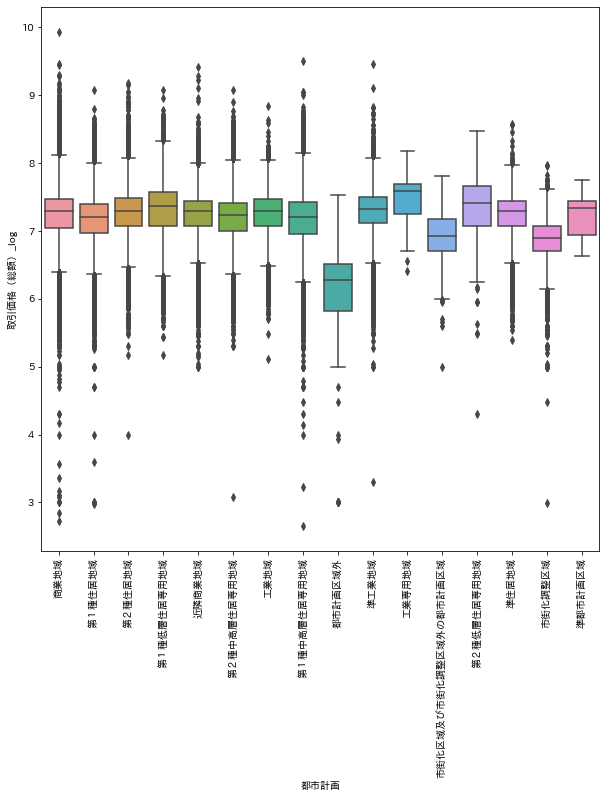

In [215]:
fig, ax = plt.subplots(figsize = (10,10)) 
sns.boxplot(data=train_df, x = '都市計画', y='取引価格（総額）_log')
labels = ax.get_xticklabels() 
plt.setp(labels, rotation=90);

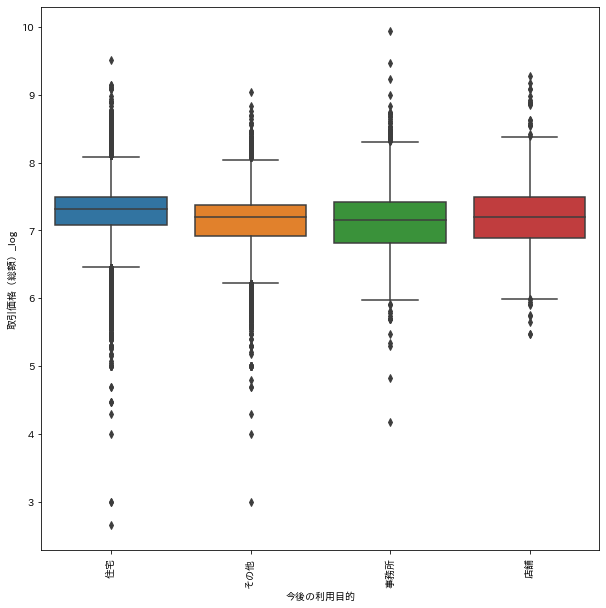

In [216]:
fig, ax = plt.subplots(figsize = (10,10)) 
sns.boxplot(data=train_df, x = '今後の利用目的', y='取引価格（総額）_log')
labels = ax.get_xticklabels() 
plt.setp(labels, rotation=90);

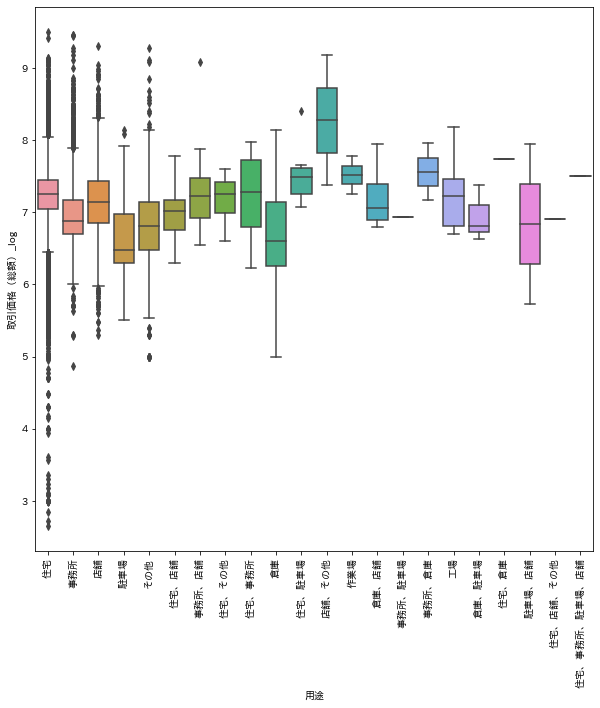

In [217]:
fig, ax = plt.subplots(figsize = (10,10)) 
sns.boxplot(data=train_df, x = '用途', y='取引価格（総額）_log')
labels = ax.get_xticklabels() 
plt.setp(labels, rotation=90);

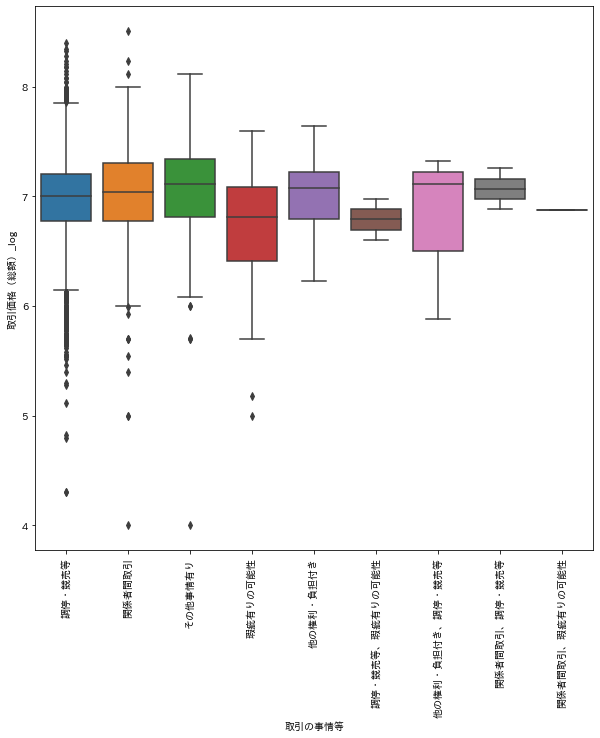

In [218]:
fig, ax = plt.subplots(figsize = (10,10)) 
sns.boxplot(data=train_df, x = '取引の事情等', y='取引価格（総額）_log')
labels = ax.get_xticklabels() 
plt.setp(labels, rotation=90);

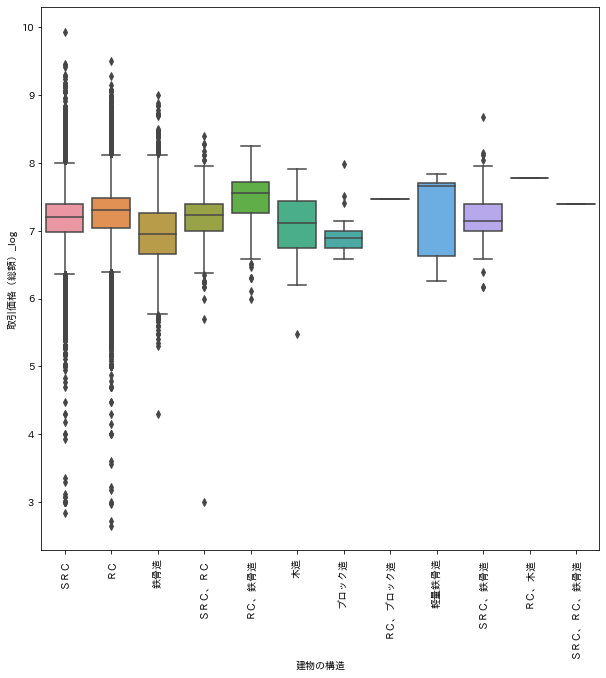

In [219]:
fig, ax = plt.subplots(figsize = (10,10)) 
sns.boxplot(data=train_df, x = '建物の構造', y='取引価格（総額）_log')
labels = ax.get_xticklabels() 
plt.setp(labels, rotation=90);

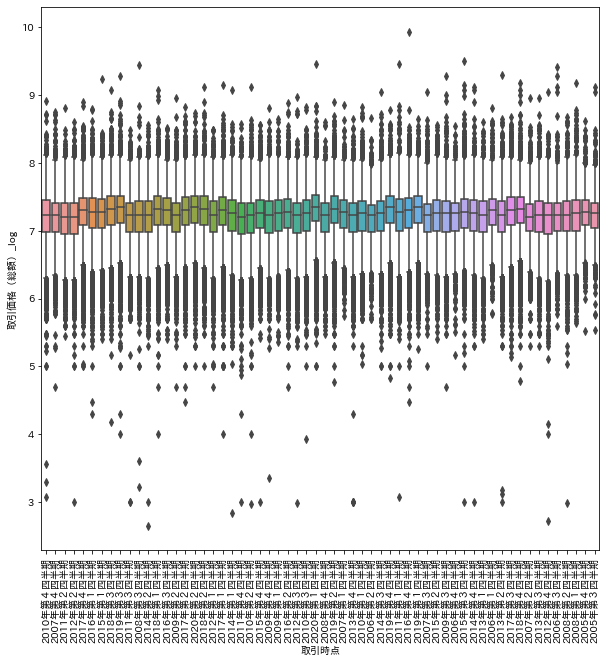

In [220]:
fig, ax = plt.subplots(figsize = (10,10)) 
sns.boxplot(data=train_df, x = '取引時点', y='取引価格（総額）_log')
labels = ax.get_xticklabels() 
plt.setp(labels, rotation=90);

In [221]:
temp = train_df[train_df['取引の事情等']=="調停・競売等"]
temp = temp[(temp['用途']!="住宅") & (temp['用途']!="事務所") & (temp['用途']!="店舗") ]

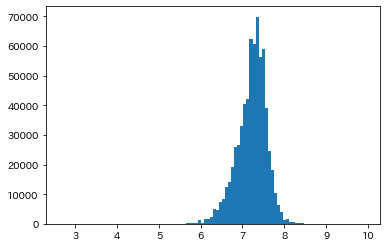

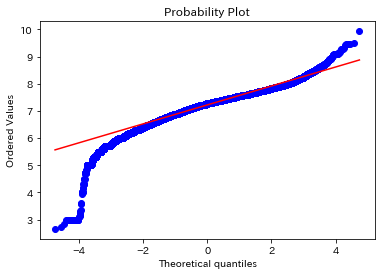

(0.9677258133888245, 0.0)


In [222]:
#正規分布の確認
def check_norm(x):
    plt.hist(x, bins=100)#ヒストグラム表示
    plt.pause(.01)
    stats.probplot(x, dist="norm", plot=plt)#QQプロット表示
    plt.pause(.01)
    p=stats.shapiro(x)#シャピロウィルク検定
    print(p)

check_norm(train_df['取引価格（総額）_log'])

# 前処理

## 間取り

In [223]:
#部屋数
def count_room_num(x):

    if x == "オープンフロア":
        x=1
        return x
    elif x == "メゾネット":
        x=1
        return x
    elif x == "スタジオ":
        x=1
        return x
    else:
        x=x[0]
        return x

#リビング数
def liv_num(x):
    if "Ｌ" in str(x):
        x = str(x).count("Ｌ")
        return x
    else:
        x=0
        return x

#キッチン数
def kitchen_num(x):
    if "Ｋ" in x:
        x = x.count("Ｋ")
        return x
    else:
        x=0
        return x

#ダイニング数
def dining_num(x):
    if "Ｄ" in x:
        x = x.count("Ｄ")
        return x
    else:
        x=0
        return x

#サービス数
def service_num(x):
    if "Ｓ" in x:
        x = x.count("Ｓ")
        return x
    else:
        x=0
        return x

#オープンフロア
def open_num(x):
    if x == "オープンフロア":
        x = 1
        return x
    else:
        x=0
        return x

#メゾネット
def mez_num(x):
    if x == "メゾネット":
        x=1
        return x
    else:
        x=0
        return x

#スタジオ
def studio_num(x):
    if x == "スタジオ":
        x= 1
        return x
    else:
        x=0
        return x
    

In [224]:
train_df["間取り"]=train_df["間取り"].fillna("1")
train_df["room_num"] = train_df["間取り"].apply(lambda x: count_room_num(x)).astype(int)
train_df["living_num"] = train_df["間取り"].apply(lambda x: liv_num(x)).astype(int)
train_df["kitchen_num"] = train_df["間取り"].apply(lambda x: kitchen_num(x)).astype(int)
train_df["dining_num"] = train_df["間取り"].apply(lambda x: dining_num(x)).astype(int)
train_df["service_num"] = train_df["間取り"].apply(lambda x: service_num(x)).astype(int)
train_df["open_num"] = train_df["間取り"].apply(lambda x: open_num(x)).astype(int)
train_df["mez_num"] = train_df["間取り"].apply(lambda x: mez_num(x)).astype(int)
train_df["studio_num"] = train_df["間取り"].apply(lambda x: studio_num(x)).astype(int)
train_df = train_df.drop(columns=["間取り"])


test_df["間取り"]=test_df["間取り"].fillna("1")
test_df["room_num"] = test_df["間取り"].apply(lambda x: count_room_num(x)).astype(int)
test_df["living_num"] = test_df["間取り"].apply(lambda x: liv_num(x)).astype(int)
test_df["kitchen_num"] = test_df["間取り"].apply(lambda x: kitchen_num(x)).astype(int)
test_df["dining_num"] = test_df["間取り"].apply(lambda x: dining_num(x)).astype(int)
test_df["service_num"] = test_df["間取り"].apply(lambda x: service_num(x)).astype(int)
test_df["open_num"] = test_df["間取り"].apply(lambda x: open_num(x)).astype(int)
test_df["mez_num"] = test_df["間取り"].apply(lambda x: mez_num(x)).astype(int)
test_df["studio_num"] = test_df["間取り"].apply(lambda x: studio_num(x)).astype(int)
test_df = test_df.drop(columns=["間取り"])

In [225]:
train_df.head()

,ID,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,room_num,living_num,kitchen_num,dining_num,service_num,open_num,mez_num,studio_num
0,4018044,4103,宮城県,仙台市若林区,大和町,仙台,30分?60分,70,平成3年,ＳＲＣ,住宅,NaN,商業地域,80.0,400.0,2010年第４四半期,未改装,NaN,6.944483,3,1,1,1,0,0,0,0
1,4010601,4101,宮城県,仙台市青葉区,星陵町,北四番丁,15,45,昭和59年,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2007年第４四半期,改装済,NaN,6.929419,3,0,1,0,0,0,0,0
2,4014959,4102,宮城県,仙台市宮城野区,栄,中野栄,7,65,平成18年,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2011年第２四半期,未改装,NaN,7.230449,3,1,1,1,0,0,0,0
3,4004466,4101,宮城県,仙台市青葉区,梅田町,東照宮,9,65,昭和63年,ＲＣ,住宅,NaN,第２種住居地域,60.0,200.0,2012年第２四半期,改装済,NaN,7.079181,3,1,1,1,0,0,0,0
4,4002715,4101,宮城県,仙台市青葉区,国見,東北福祉大前,15,60,平成7年,ＲＣ,住宅,NaN,第１種低層住居専用地域,50.0,80.0,2010年第４四半期,未改装,NaN,6.812913,3,1,1,1,0,0,0,0


In [226]:
train_df.shape

(662799, 27)

## 構造

In [227]:
#構造
def structure_remove(input_df):

    structure = ['ブロック造', '木造', 'ＲＣ、ブロック造', 'ＲＣ、木造', 'ＳＲＣ、鉄骨造', 'ＳＲＣ、ＲＣ、鉄骨造']
    input_df = input_df.copy()
    for col in structure:
        input_df = input_df[input_df["建物の構造"] != col] 
    output_df = input_df

    return output_df

In [228]:
train_df = structure_remove(train_df)

In [229]:
train_df.shape

(662540, 27)

## 最寄り駅

In [230]:
#最寄り駅前処理
def normalize_moyori(input_df):

    input_df = input_df.copy()
    input_df['最寄駅：距離（分）']=input_df['最寄駅：距離（分）'].replace({'30分?60分':45,'1H?1H30':75,'1H30?2H':105,'2H?':120}).astype(float)
    output_df = input_df

    return output_df

In [231]:
train_df = normalize_moyori(train_df)
test_df = normalize_moyori(test_df)

In [232]:
train_df.shape

(662540, 27)

## 面積

In [233]:
#面積前処理
def normalize_area_func(x):
    x = int(re.sub('m\^2未満|㎡以上', '', str(x)))
    return x


def normalize_area(input_df):
    input_df = input_df.copy()
    input_df["面積（㎡）"]=input_df["面積（㎡）"].apply(lambda x:normalize_area_func(x))
    input_df["面積（㎡）"] =input_df["面積（㎡）"].astype(int)
    output_df = input_df

    return output_df

In [234]:
train_df = normalize_area(train_df)
test_df = normalize_area(test_df)

In [235]:
train_df.shape

(662540, 27)

## 築年数

In [236]:
#建築年前処理
def convert_wareki_to_seireki_func(x):
    if x == x:
        if x == '戦前':
            x = '昭和20年'
        value = x[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in x:
            seireki = 1925+value
        elif '平成' in x:
            seireki = 1988+value
        elif '令和' in x:
            seireki = 2018+value
    else:
        seireki = x
    return seireki

def convert_wareki_to_seireki(input_df):
    input_df = input_df.copy()
    input_df['建築年']=input_df['建築年'].apply(lambda x:convert_wareki_to_seireki_func(x))
    input_df['建築年'] =input_df['建築年']
    output_df = input_df

    return output_df

def fill_build_year(input_df):
    input_df = input_df.copy()
    input_df['建築年']=input_df['建築年'].fillna(input_df['建築年'].mode())
    input_df['建築年'] =input_df['建築年']
    output_df = input_df

    return output_df



In [237]:
train_df = fill_build_year(train_df)
train_df = convert_wareki_to_seireki(train_df)

test_df = fill_build_year(test_df)
test_df = convert_wareki_to_seireki(test_df)

In [238]:
train_df.shape

(662540, 27)

## 用途

In [239]:
#構造
def function_remove(input_df):

    structure = list(set(train_df["用途"].unique()) ^ set(test_df["用途"].unique()))
    input_df = input_df.copy()
    for col in structure:
        input_df = input_df[input_df["用途"] != col] 
    output_df = input_df

    return output_df

In [240]:
train_df = function_remove(train_df)

In [241]:
train_df.shape

(662483, 27)

## 都市計画

In [242]:
#都市計画
def keikaku_remove(input_df):

    structure = list(set(train_df["都市計画"].unique()) ^ set(test_df["都市計画"].unique()))
    input_df = input_df.copy()
    for col in structure:
        input_df = input_df[input_df["都市計画"] != col] 
    output_df = input_df

    return output_df

In [243]:
train_df = keikaku_remove(train_df)

In [244]:
train_df.shape

(662476, 27)

In [245]:
test_df.shape

(23204, 26)

## 取引の事情等

In [246]:
#取引の事情
def torihiki_remove(input_df):

    structure = list(set(train_df["取引の事情等"].unique()) ^ set(test_df["取引の事情等"].unique()))
    input_df = input_df.copy()
    for col in structure:
        input_df = input_df[input_df["取引の事情等"] != col] 
    output_df = input_df

    return output_df

In [247]:
train_df = torihiki_remove(train_df)

In [248]:
train_df

,ID,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,room_num,living_num,kitchen_num,dining_num,service_num,open_num,mez_num,studio_num
0,4018044,4103,宮城県,仙台市若林区,大和町,仙台,45.0,70,1991.0,ＳＲＣ,住宅,NaN,商業地域,80.0,400.0,2010年第４四半期,未改装,NaN,6.944483,3,1,1,1,0,0,0,0
1,4010601,4101,宮城県,仙台市青葉区,星陵町,北四番丁,15.0,45,1984.0,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2007年第４四半期,改装済,NaN,6.929419,3,0,1,0,0,0,0,0
2,4014959,4102,宮城県,仙台市宮城野区,栄,中野栄,7.0,65,2006.0,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2011年第２四半期,未改装,NaN,7.230449,3,1,1,1,0,0,0,0
3,4004466,4101,宮城県,仙台市青葉区,梅田町,東照宮,9.0,65,1988.0,ＲＣ,住宅,NaN,第２種住居地域,60.0,200.0,2012年第２四半期,改装済,NaN,7.079181,3,1,1,1,0,0,0,0
4,4002715,4101,宮城県,仙台市青葉区,国見,東北福祉大前,15.0,60,1995.0,ＲＣ,住宅,NaN,第１種低層住居専用地域,50.0,80.0,2010年第４四半期,未改装,NaN,6.812913,3,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662794,46014167,46218,鹿児島県,霧島市,霧島田口,霧島神宮,75.0,145,1990.0,ＳＲＣ,住宅,NaN,都市計画区域外,NaN,NaN,2011年第３四半期,未改装,NaN,7.477121,3,1,1,1,0,0,0,0
662795,46019613,46201,鹿児島県,鹿児島市,平之町,鹿児島中央,18.0,50,NaN,NaN,住宅,住宅,商業地域,80.0,400.0,2019年第１四半期,未改装,NaN,6.875061,2,1,1,1,0,0,0,0
662796,46055056,46201,鹿児島県,鹿児島市,田上,鹿児島中央,28.0,25,1990.0,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2009年第４四半期,改装済,調停・競売等,6.342423,1,0,1,0,0,0,0,0
662797,46011239,46201,鹿児島県,鹿児島市,加治屋町,鹿児島中央,18.0,80,2003.0,ＳＲＣ,住宅,住宅,商業地域,80.0,500.0,2015年第３四半期,未改装,NaN,7.397940,3,1,1,1,0,0,0,0


## 取引時点

In [249]:
train_df["取引年"] = train_df["取引時点"].apply(lambda x: x[:4]).astype(int)
train_df = train_df.drop(columns=["取引時点"])
test_df["取引年"] = test_df["取引時点"].apply(lambda x: x[:4]).astype(int)
test_df = test_df.drop(columns=["取引時点"])
train_df["取引年"]

0         2010
1         2007
2         2011
3         2012
4         2010
          ... 
662794    2011
662795    2019
662796    2009
662797    2015
662798    2019
Name: 取引年, Length: 662422, dtype: int64

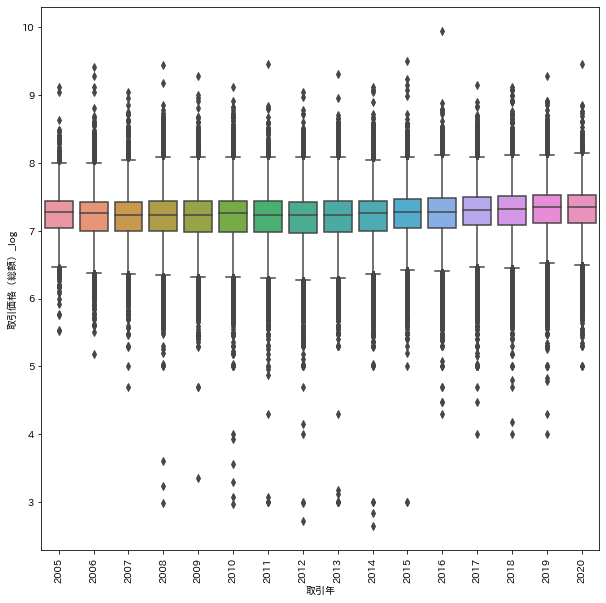

In [250]:
fig, ax = plt.subplots(figsize = (10,10)) 
sns.boxplot(data=train_df, x = '取引年', y='取引価格（総額）_log')
labels = ax.get_xticklabels() 
plt.setp(labels, rotation=90);

In [251]:
ｔrain_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662422 entries, 0 to 662798
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            662422 non-null  int64  
 1   市区町村コード       662422 non-null  int64  
 2   都道府県名         662422 non-null  object 
 3   市区町村名         662422 non-null  object 
 4   地区名           661764 non-null  object 
 5   最寄駅：名称        659773 non-null  object 
 6   最寄駅：距離（分）     639370 non-null  float64
 7   面積（㎡）         662422 non-null  int64  
 8   建築年           643309 non-null  float64
 9   建物の構造         646834 non-null  object 
 10  用途            608511 non-null  object 
 11  今後の利用目的       299134 non-null  object 
 12  都市計画          643431 non-null  object 
 13  建ぺい率（％）       639387 non-null  float64
 14  容積率（％）        639387 non-null  float64
 15  改装            602384 non-null  object 
 16  取引の事情等        18394 non-null   object 
 17  取引価格（総額）_log  662422 non-null  float64
 18  room

## 数値カラムの可視化

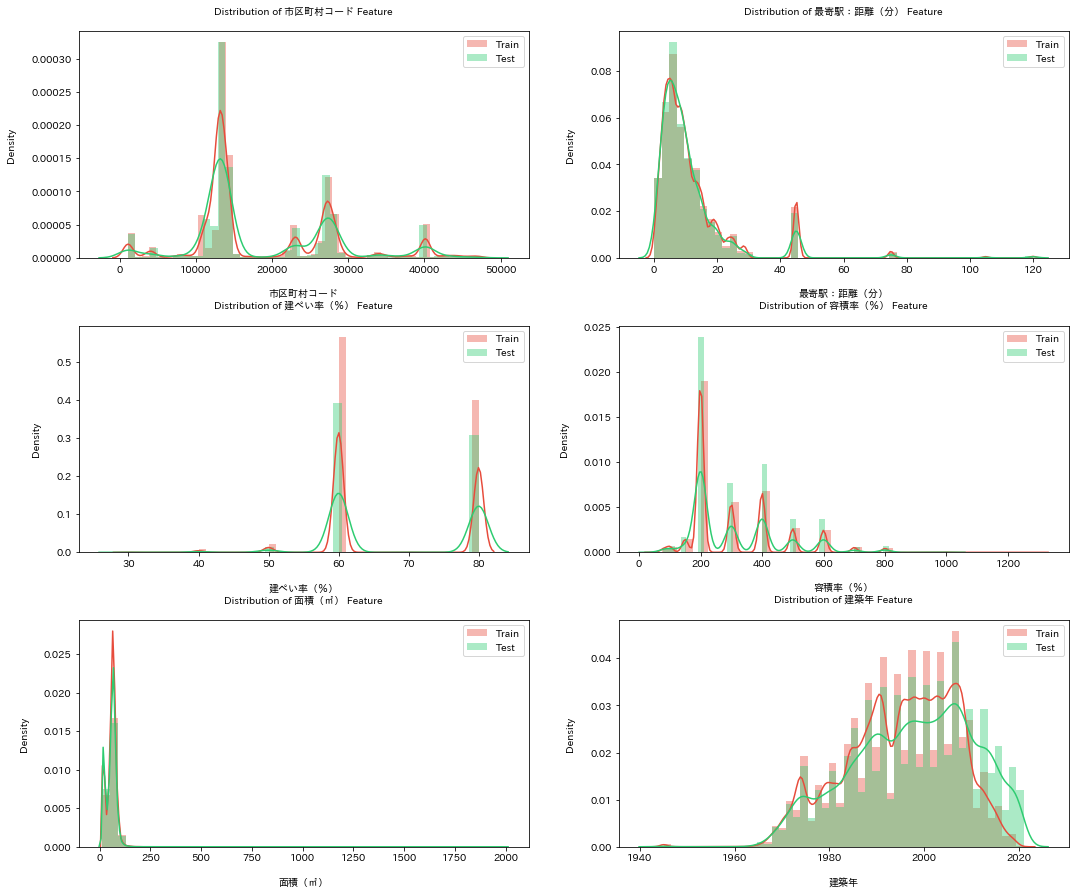

In [252]:
cont_features = ['市区町村コード',"最寄駅：距離（分）",'建ぺい率（％）', '容積率（％）',"面積（㎡）","建築年"]

vs.Numeric_features_plot(train_df,test_df,cont_features=cont_features, height=5, figsize=10)

## カテゴリカル変数の可視化

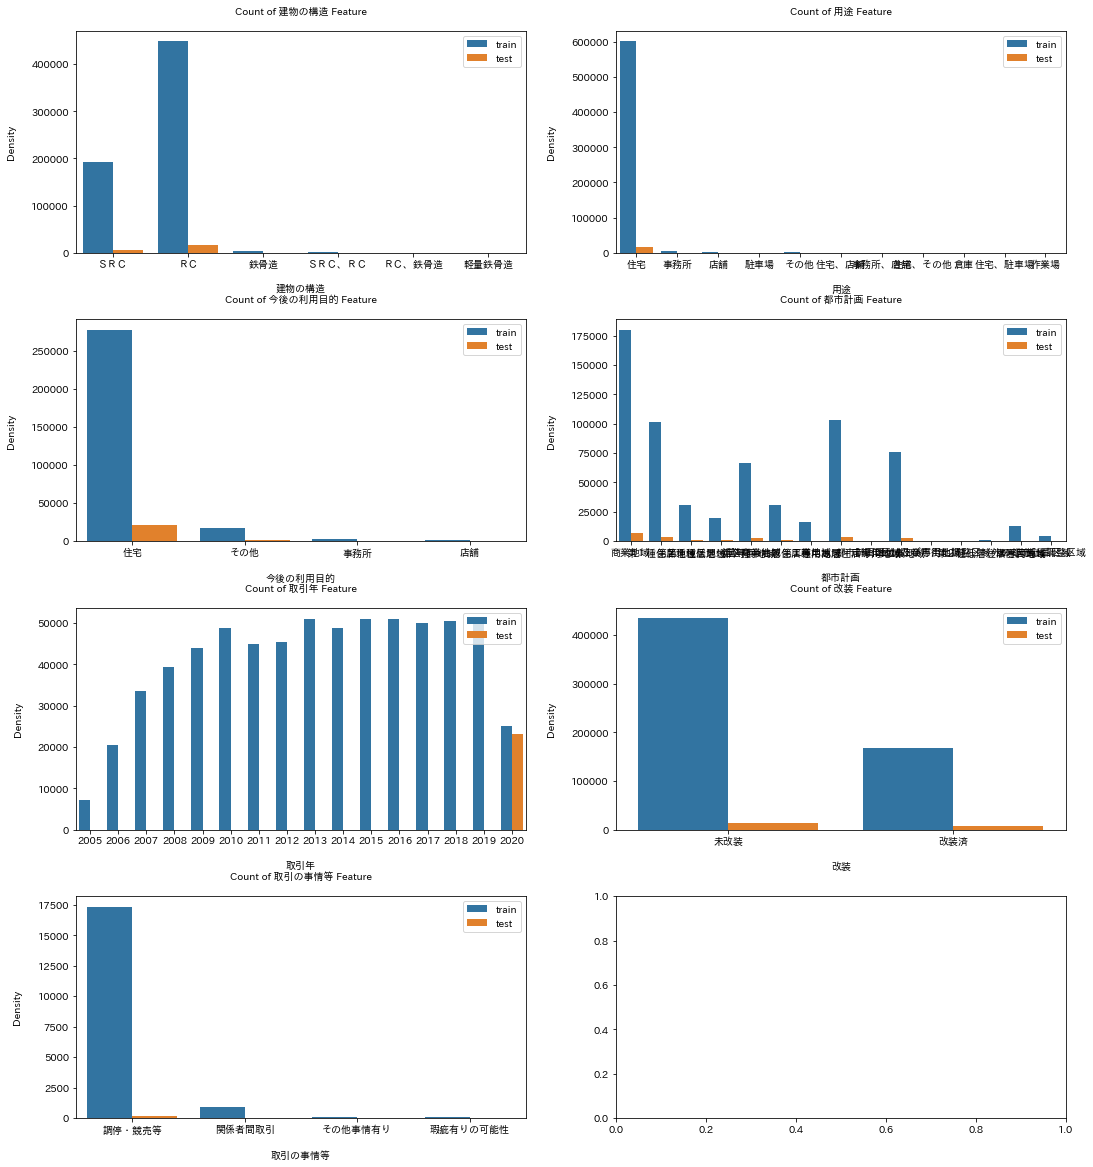

In [253]:
cat_features= ['建物の構造','用途', '今後の利用目的','都市計画', '取引年', '改装','取引の事情等']

vs.Categorical_features_plot(train_df,test_df,cat_features=cat_features, height=5, figsize=10)

## テストデータに含まれない項目の削除

In [254]:
remove_shikutyo_id=list(set(test_df["市区町村コード"].unique())^set(train_df["市区町村コード"].unique()))
remove_chiku_id=list(set(test_df["地区名"].unique())^set(train_df["地区名"].unique()))
remove_eki_id=list(set(test_df["最寄駅：名称"].unique())^set(train_df["最寄駅：名称"].unique()))
remove_area_id=list(set(test_df["面積（㎡）"].unique())^set(train_df["面積（㎡）"].unique()))
remove_kenchiku_id=list(set(test_df["建築年"].unique())^set(train_df["建築年"].unique()))
remove_you_id=list(set(test_df["容積率（％）"].unique())^set(train_df["容積率（％）"].unique()))
remove_ken_id=list(set(test_df["建ぺい率（％）"].unique())^set(train_df["建ぺい率（％）"].unique()))

def  remove_train(x,target_id):
    if x in target_id:
        x=999
        return x
    else:
        return x

train_df["市区町村コード"] = train_df["市区町村コード"].apply(lambda x: remove_train(x,remove_shikutyo_id))
train_df = train_df[train_df["市区町村コード"]!=999].reset_index(drop=True)

train_df["地区名"] = train_df["地区名"].apply(lambda x: remove_train(x,remove_chiku_id))
train_df = train_df[train_df["地区名"]!=999].reset_index(drop=True)

train_df["最寄駅：名称"] = train_df["最寄駅：名称"].apply(lambda x: remove_train(x,remove_eki_id))
train_df = train_df[train_df["最寄駅：名称"]!=999].reset_index(drop=True)

train_df["面積（㎡）"] = train_df["面積（㎡）"].apply(lambda x: remove_train(x,remove_area_id))
train_df = train_df[train_df["面積（㎡）"]!=999].reset_index(drop=True)

train_df["建築年"] = train_df["建築年"].apply(lambda x: remove_train(x,remove_kenchiku_id))
train_df = train_df[train_df["建築年"]!=999].reset_index(drop=True)

train_df["容積率（％）"] = train_df["容積率（％）"].apply(lambda x: remove_train(x,remove_you_id))
train_df = train_df[train_df["容積率（％）"]!=999].reset_index(drop=True)

train_df["建ぺい率（％）"] = train_df["建ぺい率（％）"].apply(lambda x: remove_train(x,remove_ken_id))
train_df = train_df[train_df["建ぺい率（％）"]!=999].reset_index(drop=True)

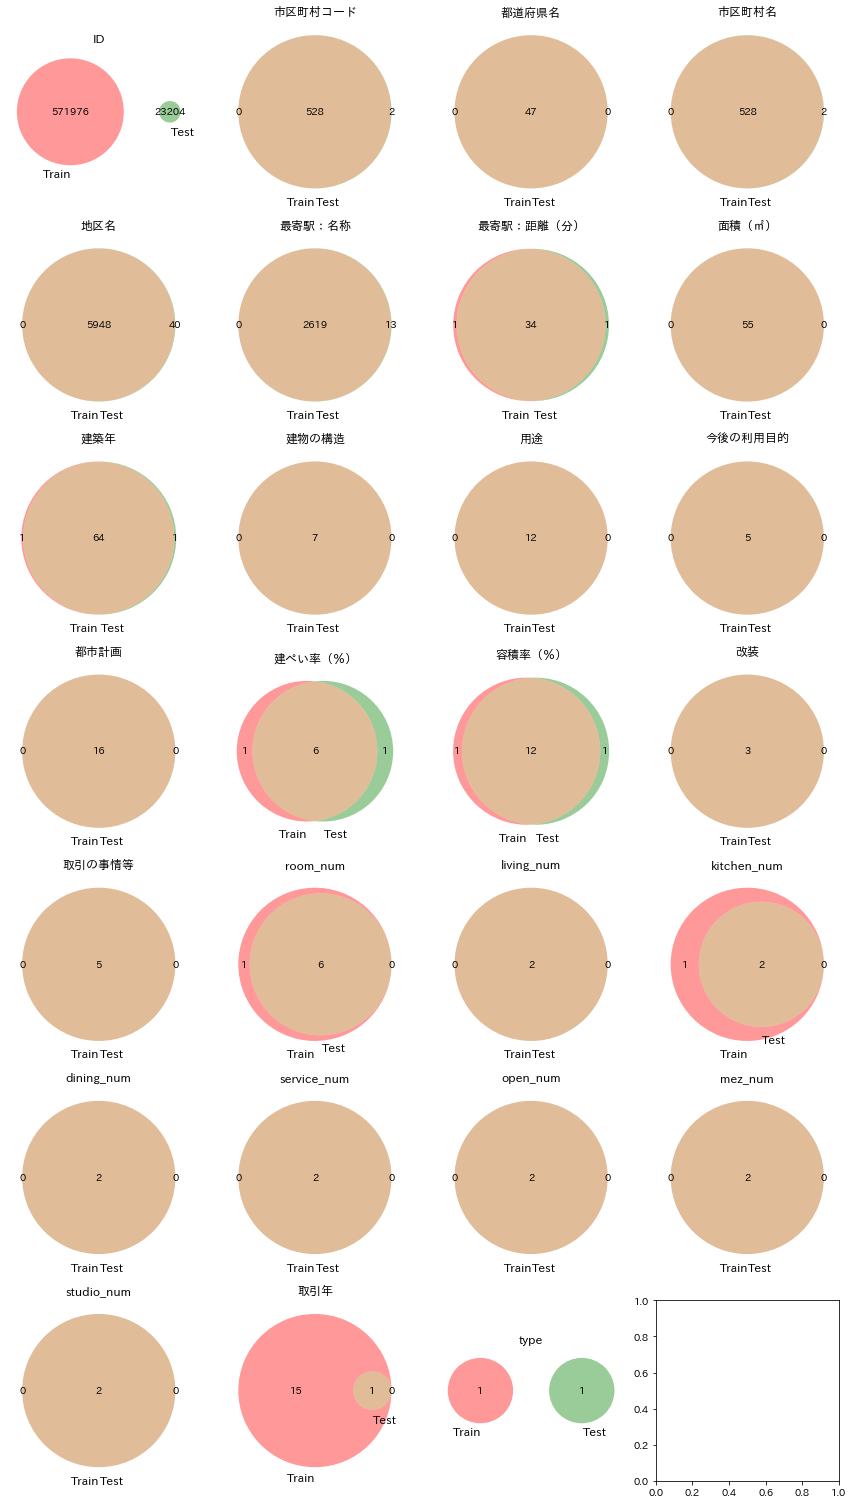

In [255]:
vs.Venn_plot(train_df,test_df)

## カテゴリカルエンコーディング

In [258]:
train_df["type"]= "train"
test_df["type"]= "test"

others_train_df = train_df[train_df['都道府県名']!="東京都"].reset_index(drop=True)
tokyo_train_df = train_df[train_df['都道府県名']=="東京都"].reset_index(drop=True)

others_test_df = test_df[test_df['都道府県名']!="東京都"].reset_index(drop=True)
tokyo_test_df = test_df[test_df['都道府県名']=="東京都"].reset_index(drop=True)

In [259]:
train_df.columns

Index(['ID', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称', '最寄駅：距離（分）',
       '面積（㎡）', '建築年', '建物の構造', '用途', '今後の利用目的', '都市計画', '建ぺい率（％）', '容積率（％）',
       '改装', '取引の事情等', '取引価格（総額）_log', 'room_num', 'living_num', 'kitchen_num',
       'dining_num', 'service_num', 'open_num', 'mez_num', 'studio_num', '取引年',
       'type'],
      dtype='object')

In [262]:
enco = preprocess_module.Encoding_Module()

count_col = ["市区町村コード",
             '都道府県名',
             "地区名",
             '最寄駅：名称',
             "建築年",
             '建物の構造',
             '用途',
             '今後の利用目的',
             '都市計画',
             #'取引年',
             '改装',
             '取引の事情等']


input_df = pd.concat([others_train_df, others_test_df]).reset_index(drop=True)

input_df = enco.CountEncoding_(target_cols=count_col,_input_df=input_df)
input_df = enco.LabelEncoding_(target_cols=count_col,_input_df=input_df)
input_df = enco.TargetEncoding_(target_cols=count_col,_input_df=input_df,target=input_df["取引価格（総額）_log"])

others_train_df = input_df[input_df["type"]=="train"].reset_index(drop=True)
others_test_df = input_df[input_df["type"]=="test"].reset_index(drop=True)

count_col = ["市区町村コード",
             #'都道府県名',
             "地区名",
             '最寄駅：名称',
             "建築年",
             '建物の構造',
             '用途',
             '今後の利用目的',
             '都市計画',
             #'取引年',
             '改装',
             '取引の事情等']

input_df_t = pd.concat([tokyo_train_df, tokyo_test_df]).reset_index(drop=True)

input_df_t = enco.CountEncoding_(target_cols=count_col,_input_df=input_df_t)
input_df_t = enco.LabelEncoding_(target_cols=count_col,_input_df=input_df_t)
input_df_t = enco.TargetEncoding_(target_cols=count_col,_input_df=input_df_t,target=input_df_t["取引価格（総額）_log"])

tokyo_train_df = input_df_t[input_df_t["type"]=="train"].reset_index(drop=True)
tokyo_test_df = input_df_t[input_df_t["type"]=="test"].reset_index(drop=True)

In [263]:
others_train_df = others_train_df.drop(columns=["ID","市区町村名","type"])
others_test_df = others_test_df.drop(columns=["市区町村名","type"])

tokyo_train_df = tokyo_train_df.drop(columns=["ID","市区町村名","type"])
tokyo_test_df = tokyo_test_df.drop(columns=["市区町村名","type"])

In [267]:
others_train_df.to_pickle(input_dir + "others_train_rev.pkl")
others_test_df.to_pickle(input_dir + "others_test_rev.pkl")

tokyo_train_df.to_pickle(input_dir + "tokyo_train_rev.pkl")
tokyo_test_df.to_pickle(input_dir + "tokyo_test_rev.pkl")

# モデル(学習)

In [268]:
others_df_train = pd.read_pickle(input_dir + "others_train_rev.pkl")
others_df_test = pd.read_pickle(input_dir + "others_test_rev.pkl")

tokyo_df_train=pd.read_pickle(input_dir + "tokyo_train_rev.pkl")
tokyo_df_test=pd.read_pickle(input_dir + "tokyo_test_rev.pkl")

In [269]:
others_df_train = others_df_train[others_df_train["取引年"] > 2016].reset_index(drop=True)
tokyo_df_train = tokyo_df_train[tokyo_df_train["取引年"] > 2016].reset_index(drop=True)

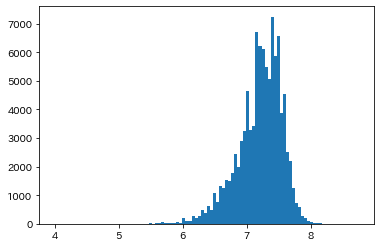

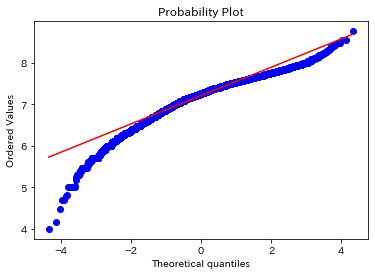

(0.9559715390205383, 0.0)


In [270]:
check_norm(others_df_train['取引価格（総額）_log'])

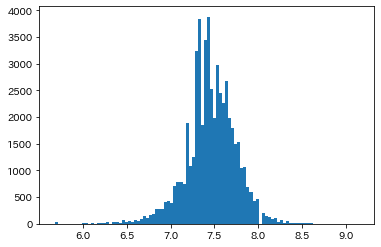

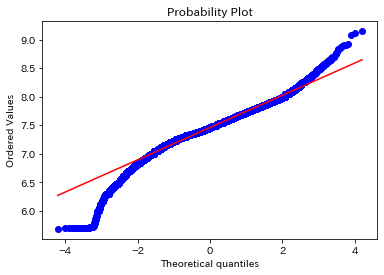

(0.9731853604316711, 0.0)


In [271]:
check_norm(tokyo_df_train['取引価格（総額）_log'])

In [272]:
count_col = ["市区町村コード",
             '都道府県名',
             "地区名",
             '最寄駅：名称',
             "建築年",
             '建物の構造',
             '用途',
             '今後の利用目的',
             '都市計画',
             #'取引年',
             '改装',
             '取引の事情等']
             
others_df_train = others_df_train.drop(columns=count_col)
others_df_test = others_df_test.drop(columns=count_col)

tokyo_df_train = tokyo_df_train.drop(columns=count_col)
tokyo_df_test = tokyo_df_test.drop(columns=count_col)

In [273]:
others_train_y = others_df_train["取引価格（総額）_log"]
others_train_x = others_df_train.drop(columns=["取引価格（総額）_log"])

tokyo_train_y = tokyo_df_train["取引価格（総額）_log"]
tokyo_train_x = tokyo_df_train.drop(columns=["取引価格（総額）_log"])

In [274]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_absolute_error

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=-1)

        pred_i = clf.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} MAE: {metric_func(y_valid, pred_i) :.4f}')

    score = metric_func(y, oof_pred)
    print('FINISHED | Whole MAE: {:.4f}'.format(score))
    return oof_pred, models

def fit_xgb(X, y, cv, params: dict=None, verbose: int=50):
    metric_func = mean_absolute_error
    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        
        model_xgb = xgb.XGBRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            model_xgb.fit(x_train, y_train, 
                          eval_set=[(x_valid, y_valid)],
                          early_stopping_rounds=verbose)
            
        #print(model_xgb.best_score())
        
        pred_i = model_xgb.predict(x_valid)

        oof_pred[idx_valid] = pred_i
        models.append(model_xgb)

        print(f'Fold {i} MAE: {metric_func(y_valid, pred_i):.4f}')

    score = metric_func(y, oof_pred)
    print('FINISHED | Whole MAE: {:.4f}'.format(score))
    return oof_pred, models

In [275]:
lgm_params = {  
    "n_estimators": 10000,
    "objective": 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 36,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .5,
    "reg_lambda": 5,
    "max_depth":5,
    }

fold = KFold(n_splits=10, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(others_train_x, others_train_y))
oof_others, models_others = fit_lgbm(others_train_x.values, others_train_y, cv , params=lgm_params)

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[9999]	valid_0's rmse: 0.131531
fit fold=1 192.933[s]
Fold 0 MAE: 0.0843
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[10000]	valid_0's rmse: 0.132057
fit fold=2 193.721[s]
Fold 1 MAE: 0.0847
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[9992]	valid_0's rmse: 0.13376
fit fold=3 193.859[s]
Fold 2 MAE: 0.0842
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[10000]	valid_0's rmse: 0.130309
fit fold=4 192.105[s]
Fold 3 MAE: 0.0834
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[10000]	valid_0's rmse: 0.134541
fit fold=5 189.229[s]
Fold 4 MAE: 0.0846
Training until validation scores don't improve for 50 rounds.
Did not meet early st

In [276]:
fold = KFold(n_splits=10, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(tokyo_train_x, tokyo_train_y))
oof_tokyo, models_tokyo = fit_lgbm(tokyo_train_x.values, tokyo_train_y, cv , params=lgm_params)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[6470]	valid_0's rmse: 0.0894176
fit fold=1 38.170[s]
Fold 0 MAE: 0.0573
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8732]	valid_0's rmse: 0.0911949
fit fold=2 44.390[s]
Fold 1 MAE: 0.0587
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5397]	valid_0's rmse: 0.0962802
fit fold=3 28.790[s]
Fold 2 MAE: 0.0599
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[9902]	valid_0's rmse: 0.0900147
fit fold=4 50.097[s]
Fold 3 MAE: 0.0566
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[5082]	valid_0's rmse: 0.0950747
fit fold=5 26.979[s]
Fold 4 MAE: 0.0586
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8044]	valid_0's rmse: 0.0997935
fit fold=6 41.024[s]

In [278]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

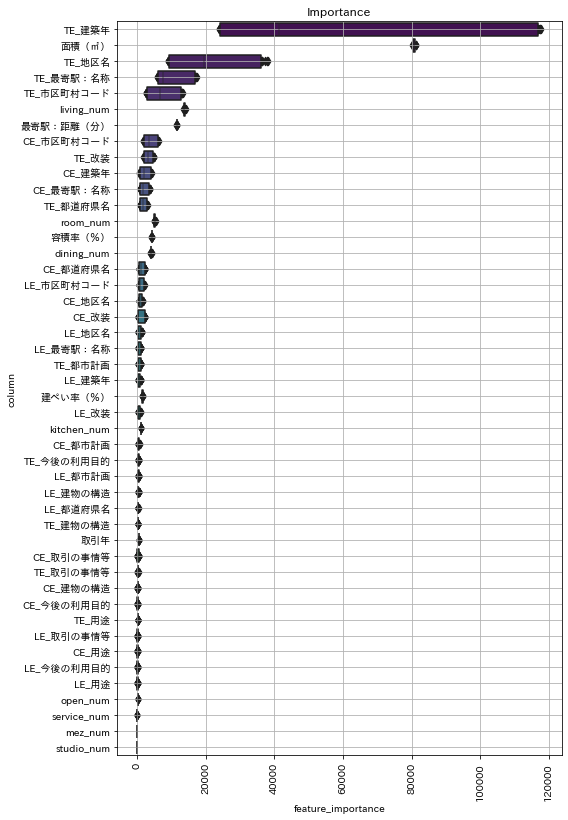

In [279]:
fig, ax = visualize_importance(models_others, others_train_x)

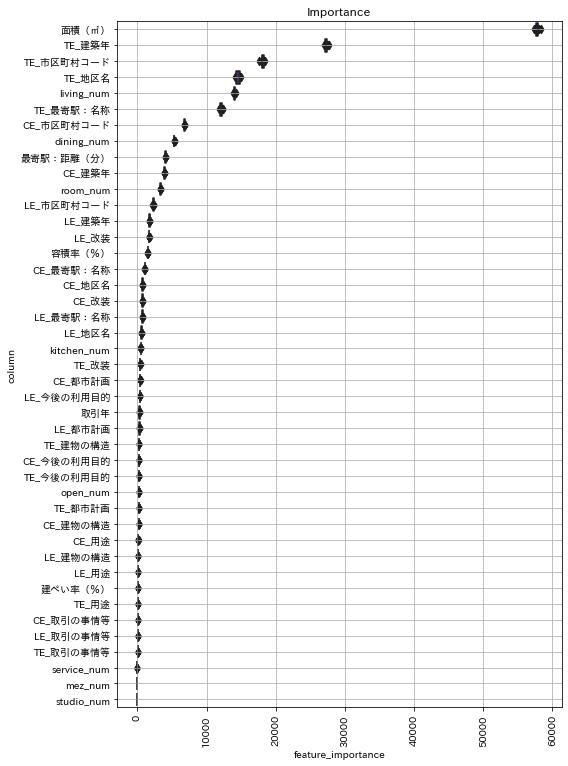

In [280]:
fig, ax = visualize_importance(models_tokyo, tokyo_train_x)

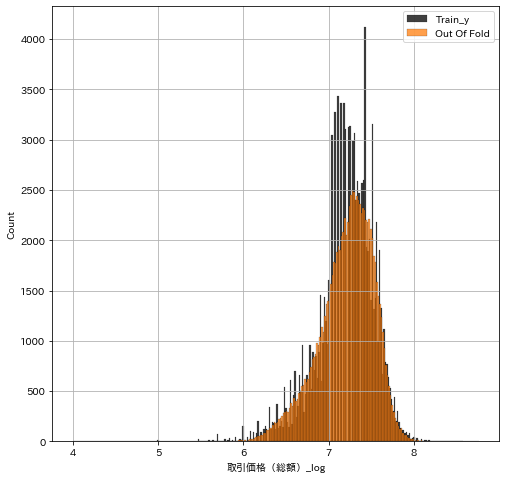

In [281]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(others_train_y, label='Train_y', ax=ax, color='black')
sns.histplot(oof_others, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

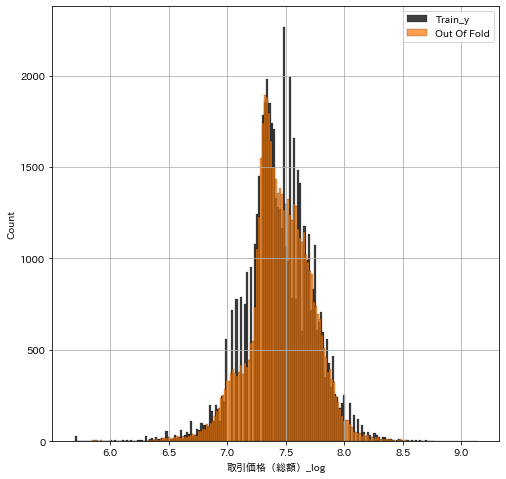

In [282]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(tokyo_train_y, label='Train_y', ax=ax, color='black')
sns.histplot(oof_tokyo, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()

# モデル(推論)

In [283]:
submission_df = pd.read_csv(input_dir + "sample_submission.csv")

In [284]:
submission_df

,ID,取引価格（総額）_log
0,1000114,0
1,1000116,0
2,1000117,0
3,1000118,0
4,1000119,0
...,...,...
23199,47012519,0
23200,47014760,0
23201,47014956,0
23202,47015505,0


In [285]:
others_ids = others_df_test["ID"]
others_df_test = others_df_test.drop(columns=["ID","取引価格（総額）_log"])

In [286]:
pred_others = np.array([model.predict(others_df_test.values) for model in models_others])
pred_others = np.mean(pred_others, axis=0)

submission_pred_others = pd.DataFrame()
submission_pred_others["ID"] = others_ids
submission_pred_others["取引価格（総額）_log"] =pred_others
submission_pred_others

,ID,取引価格（総額）_log
0,1000114,6.967354
1,1000116,6.923877
2,1000117,7.184727
3,1000118,7.497441
4,1000119,6.402497
...,...,...
15803,47012519,7.536674
15804,47014760,7.108197
15805,47014956,6.759710
15806,47015505,6.933566


In [287]:
tokyo_ids = tokyo_df_test["ID"]
tokyo_df_test = tokyo_df_test.drop(columns=["ID","取引価格（総額）_log"])

In [288]:
pred_tokyo = np.array([model.predict(tokyo_df_test.values) for model in models_tokyo])
pred_tokyo = np.mean(pred_tokyo, axis=0)

submission_pred_tokyo = pd.DataFrame()
submission_pred_tokyo["ID"] = tokyo_ids
submission_pred_tokyo["取引価格（総額）_log"] =pred_tokyo
submission_pred_tokyo

,ID,取引価格（総額）_log
0,13002079,7.624353
1,13002080,7.397434
2,13002081,7.452820
3,13002082,7.915550
4,13002147,7.364641
...,...,...
7391,13429097,7.549159
7392,13429099,7.538144
7393,13429100,7.592466
7394,13429101,7.620091


In [289]:
submission_pred_df = pd.concat([submission_pred_others, submission_pred_tokyo], axis=0)

In [290]:
submission_df = pd.read_csv(input_dir + "sample_submission.csv")
submission_df = submission_df.drop("取引価格（総額）_log", axis=1)
submission_df = pd.merge(submission_df, submission_pred_df[["ID", "取引価格（総額）_log"]], on="ID", how="left")

In [291]:
submission_df

,ID,取引価格（総額）_log
0,1000114,6.967354
1,1000116,6.923877
2,1000117,7.184727
3,1000118,7.497441
4,1000119,6.402497
...,...,...
23199,47012519,7.536674
23200,47014760,7.108197
23201,47014956,6.759710
23202,47015505,6.933566


In [292]:
submission_df.to_csv(output_dir +'submission_4.csv', index=False)